<a href="https://colab.research.google.com/github/MishterBluesky/ColabTree/blob/main/ColabTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***ColabTree*** (MMSEQ2 search to phylogeny)
[This simple pipeline](https://colab.research.google.com/drive/16AgcSQIa9y4iTZpT3vYshdlw28AXdjHc?usp=sharing) made by the Rodrigues lab, uses the ColabFold MMSEQ2 and HHSUITE filtering of proteins for fast protein phylogeny determination. It makes an A3M file  and a fasta file using MMSEQ2. It then translates this into a PHYLIP file and uses FASTME default settings for phylogeny determination. If you would like to only change an a3m file into a tree or label your a3m file, and do not need to search use our other pipeline "[ATree](https://colab.research.google.com/drive/1QBdca96AL37vttMwWcdKaUz3aBPd7NaI?usp=sharing)"

**Input the amino acid sequence of your protein, and this software will make a tree of the conservation of the gene or genes**. If analysing a gene cluster please untick 'protein modelling' so you dont crash the system.

For publication quality analysis, we recommend you upload the nwk file created by this programme to iTOL https://itol.embl.de/upload.cgi

 This workbook is based greatly off the Alphafold **Colabfold** notebook here: https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb#scrollTo=G4yBrceuFbf3 and published here:

*Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all. Nature Methods, 2022*

It relies on **FASTME**:

*Vincent Lefort, Richard Desper, Olivier Gascuel, FastME 2.0: A Comprehensive, Accurate, and Fast Distance-Based Phylogeny Inference Program, Molecular Biology and Evolution, Volume 32, Issue 10, October 2015, Pages 2798–2800, https://doi.org/10.1093/molbev/msv150*

To cite our tool use the following citation:



In [1]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MKIKRSFISI SVLMVIFGLM ISVQFNSLKH PKVRDTRDMW DIREELTSEQ KKQEKLLAEI NKYDKLLNSY SQTKEMTKET ALNNTLQSLK KTAGMTDITG SGIVITISPL FSESLTGEPI ENPPPDLLKK LINELNSYGA  EHISINERRV VNHTVIRDIN GTTKIDGYAL DDYPLTVKVL AKDPDMLHSR VKGSGLEDLF ASENLALKAG KSESKLTLKA YDRPLDVQQL KLLKD:MRGKSAVLLS LIMLIAGFLI SFSFQMTKEN NKSAAETEEW KKEYALRDEL LKQEKENKKF EKELYQKQNK VRQAENKLKK EKSEYYNVLE DTEKYRMYIG EVGVQGEGVE VTLEDASYIP EGENVNSYIV HESHIFQVVN  ELYISGAAAV AVNGQRLTHD SYIKCNGPVV TVDGVQHPAP FTVSAIGDPD VLLPSLNIAG GLIDQLSMDH ISVSAEKEKN VQMKPILKTK E:MWLPVLGLVL GIAIGLMTNL TIPSEYSNYL SLAVLAALDT LIGGIRAHLQ GTYDEMVFVS GFFFNIILAI SLAFLGVHLG VDLYLAGIFA FGVRLFQNIA VIRRNLLTKW TLSKKNKKNV I' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **searching gene clusters**
jobname = 'YlxX-YlxW-Sbp' #@param {type:"string"}
# number of models to use
num_relax = 0
template_mode = "none"

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



jobname YlxXYlxWSbp_fe16f
sequence MKIKRSFISISVLMVIFGLMISVQFNSLKHPKVRDTRDMWDIREELTSEQKKQEKLLAEINKYDKLLNSYSQTKEMTKETALNNTLQSLKKTAGMTDITGSGIVITISPLFSESLTGEPIENPPPDLLKKLINELNSYGAEHISINERRVVNHTVIRDINGTTKIDGYALDDYPLTVKVLAKDPDMLHSRVKGSGLEDLFASENLALKAGKSESKLTLKAYDRPLDVQQLKLLKD:MRGKSAVLLSLIMLIAGFLISFSFQMTKENNKSAAETEEWKKEYALRDELLKQEKENKKFEKELYQKQNKVRQAENKLKKEKSEYYNVLEDTEKYRMYIGEVGVQGEGVEVTLEDASYIPEGENVNSYIVHESHIFQVVNELYISGAAAVAVNGQRLTHDSYIKCNGPVVTVDGVQHPAPFTVSAIGDPDVLLPSLNIAGGLIDQLSMDHISVSAEKEKNVQMKPILKTKE:MWLPVLGLVLGIAIGLMTNLTIPSEYSNYLSLAVLAALDTLIGGIRAHLQGTYDEMVFVSGFFFNIILAISLAFLGVHLGVDLYLAGIFAFGVRLFQNIAVIRRNLLTKWTLSKKNKKNVI
length 587


In [2]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 399 ms, sys: 43 ms, total: 441 ms
Wall time: 1min 22s


In [3]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.
model_type = "auto"
# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
#@markdown ### Advanced settings
model_type = "auto"
num_recycles = "0"
recycle_early_stop_tolerance = "auto"
relax_max_iterations = 200
pairing_strategy = "complete"

max_msa = "auto"
num_seeds = 1
use_dropout = False

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2024-06-13 09:28:42,460 WARNING: no GPU detected, will be using CPU
2024-06-13 09:28:49,966 Found 3 citations for tools or databases
2024-06-13 09:28:49,966 Query 1/1: YlxXYlxWSbp_fe16f (length 587)


COMPLETE: 100%|██████████| 450/450 [elapsed: 00:02 remaining: 00:00]


2024-06-13 09:28:52,273 Saved YlxXYlxWSbp_fe16f/YlxXYlxWSbp_fe16f.pickle


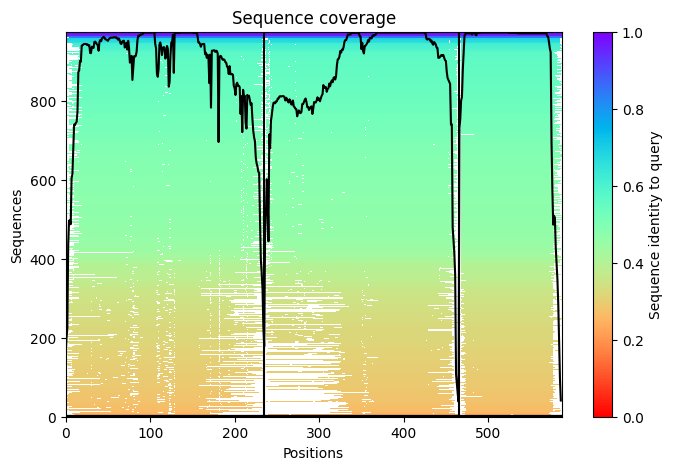

2024-06-13 09:28:53,666 Done


0

In [5]:
#@title Run Prediction
#@markdown We recommend you dont model the proteins. ColabTree will run ColabFold, but not actually model the proteins. You can model the proteins too if theyre under 1500aa total. We will not display these models by default, however they will be downloaded.
model_proteins = False #@param {type:"boolean"}
display_images = True #@param {type:"boolean"}
custom_template_path = None
if model_proteins == True:
  num_models = 1
else:
  num_models = 0
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=num_models,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [6]:
#@title Download FastME
!git clone https://gite.lirmm.fr/atgc/FastME.git
%cd FastME
!./configure
!make install

Cloning into 'FastME'...
remote: Enumerating objects: 262, done.
remote: Total 262 (delta 0), reused 0 (delta 0), pack-reused 262 (from 1)
Receiving objects: 100% (262/262), 7.03 MiB | 7.04 MiB/s, done.
Resolving deltas: 100% (137/137), done.
/content/FastME
checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a thread-safe mkdir -p... /usr/bin/mkdir -p
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking whether make supports nested variables... yes
checking build system type... x86_64-pc-linux-gnu
checking host system type... x86_64-pc-linux-gnu
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether g

In [7]:
!pip install biopython
%cd '/content'

/content


In [13]:
#@title Species assignment and creation of alignment files.
#@markdown This may take some time, we are scouring the uniprot database to find out which species are in your a3m file.
import warnings
from Bio import BiopythonWarning
import requests
import re
from Bio import SeqIO, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# Filter out the specific deprecation warning
warnings.filterwarnings("ignore", category=BiopythonWarning)

# Function to extract sequence identifier from the header
def extract_sequence_id(header):
    return header.split('_')[1]

# Function to pad sequences to the same length
def pad_sequences(sequences):
    max_length = max(len(seq) for seq in sequences)
    padded_sequences = [seq + '-' * (max_length - len(seq)) for seq in sequences]
    return padded_sequences

# Function to fetch species name from URL
def fetch_species_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        if url.startswith("https://rest.uniprot.org/uniparc/"):
            data = response.json()
            if "uniParcCrossReferences" in data and len(data["uniParcCrossReferences"]) > 0:
                organism = data["uniParcCrossReferences"][0].get("organism")
                if organism:
                    species = organism.get("scientificName")
                    if species:
                        return species
        else:  # Assuming it's a Uniprot URL
            fasta_data = response.text.split('\n')
            for line in fasta_data:
                if line.startswith(">"):
                    species = re.split(r"OX=|/|  ", line.split("OS=")[1])[0]
                    return species.replace(" ", ".")
    return None

# Function to get species name from UniProt ID
def get_species(uniprot_id):
    urls = [
        f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta",
        f"https://rest.uniprot.org/uniparc/{uniprot_id}"
    ]

    for url in urls:
        species = fetch_species_from_url(url)
        if species:
            # Ensure the species name does not exceed 50 characters
            if len(species) > 50:
                species = species[:50]
            return species

    # Return the UniProt ID if species name not found
    return uniprot_id

# Function to convert A3M file to PHYLIP file
def convert_a3m_to_phylip(a3m_file, phylip_file):
    # Parse A3M file to get sequence identifiers and sequences
    seq_records = []
    seen_ids = set()  # Set to store seen sequence identifiers
    with open(a3m_file, 'r') as f:
        skip_next = False  # Flag to skip the next line if a duplicate header is encountered
        for line in f:
            if line.startswith('#'):
                continue

            if skip_next:
                skip_next = False
                continue

            if line.startswith('>'):
                parts = line.strip().split('\t')
                pattern = ''.join(['X' if '_' in part else '0' for part in parts])
                if '>101 ' in line:
                    seq_id = 'Input.Sequence'
                else:
                    if '_' in line:
                        temp_id = line.strip().split('\t')[0]
                        if '_' in temp_id:
                            seq_id = extract_sequence_id(temp_id)
                        else:
                            temp_id = line.strip().split('\t')[1]
                            if '_' in temp_id:
                                seq_id = extract_sequence_id(temp_id)
                            else:
                                temp_id = line.strip().split('\t')[2]
                                if '_' in temp_id:
                                    seq_id = extract_sequence_id(temp_id)
                                else:
                                    temp_id = 'Unknown'
                                    seq_id = 'Unknown'
                    else:
                        seq_id = 'Unknown'

                    species = get_species(seq_id)
                    seq_id = species.replace(" ", ".")

                    # Add the pattern to the beginning of the sequence ID
                    seq_id = pattern + "." + seq_id

                    if seq_id in seen_ids:
                        skip_next = True
                        continue
                    else:
                        seen_ids.add(seq_id)
                        seq_records.append(SeqRecord(Seq(''), id=seq_id))
            else:
                if not seq_records:
                    seq_records.append(SeqRecord(Seq(''), id='Unknown'))
                seq_records[-1].seq += line.strip()

    # Pad sequences to the same length
    padded_sequences = pad_sequences([str(seq_record.seq) for seq_record in seq_records])

    # Update SeqRecords with padded sequences
    for i, seq_record in enumerate(seq_records):
        seq_record.seq = Seq(padded_sequences[i])

    # Write to PHYLIP file
    with open(phylip_file, 'w') as f:
        AlignIO.write(MultipleSeqAlignment(seq_records), f, "phylip-relaxed")
    with open(named_file, 'w') as f:
        AlignIO.write(MultipleSeqAlignment(seq_records), f, "fasta")
# Specify the path to save the PHYLIP file
phylip_file = f'{jobname}_phylip.txt'
named_file = f'{jobname}_labelled.fasta'
# Convert A3M to PHYLIP
convert_a3m_to_phylip(a3m_file, phylip_file)

# Open the PHYLIP file for reading
with open('phylip.txt', 'r') as f:
    first_line = f.readline().strip()

# Split the first line by whitespace and get the first element
first_number = first_line.split()[0]



In [9]:
with open(f'{jobname}_phylip.txt', 'rb') as f:
  phylip = content = f.read()
  phylip = phylip.replace(b'\x00', b'-')
  phylip = phylip.replace(b'>', b'-')
  phylip = phylip.replace(b'/', b'.')
with open(f'{jobname}_phylip.txt', 'wb') as f:
        f.write(phylip)

In [14]:
#@title Calculate Phylogenetic tree using FASTME
%cd /content/
!fastme -i {jobname}_phylip.txt -p
!mv {jobname}_phylip.txt_fastme_tree.nwk {jobname}_tree.nwk

/content

 . This analysis will run on 2 threads.

#  Analysing dataset 1

 . 11 sites are made from completely undetermined states ('X', '-', '?')...

 . Computing pairwise distances...

 . Warning: Give up this dataset because at least one distance exceeds 20.00.

 . Warning: Triangular inequality violation.

 . You may ask for triangular inequality correction using the '-q' option.

 . Computing tree...

 . Tree length is 690.798206.

 . Warning: 
	Explained variance = 0.239 (<0.80).
	Check your input data.

 . Time used 0h06m29s
mv: cannot stat 'phylip.txt_fastme_tree.nwk': No such file or directory


In [15]:
#@title Make your tree
!pip install toytree
import toytree
tree = toytree.tree(f'{jobname}_tree.nwk')
# Draw the tree
with open(f'{jobname}_phylip.txt', 'r') as f:
    # Read the first line from the file
    first_line = f.readline().strip()

# Split the first line by whitespace and get the first element
first_number = first_line.split()[0]
first_number = int(first_number)
height_value = round((first_number / 200) * 2000)
mystyle = {
    "tip_labels_style"
        "font-size": "5px"
    }

canvas, axes, makr= tree.draw(width=800, height = height_value, tip_labels=True, tip_labels_align=True, **mystyle)
# show the axes coordinates
axes.show = True
axes.x.ticks.show = True
axes.y.ticks.show = True

# overlay a grid
axes.vlines(0, style={"stroke": "blue", "stroke-dasharray": "2,4"});
import toyplot.svg
toyplot.svg.render(canvas, f"{jobname}_tree.svg")

canvas, axes, makr= tree.draw(width=800, height = height_value, tip_labels=True, tip_labels_align=True, **mystyle)
# show the axes coordinates
axes.show = True
axes.x.ticks.show = True
axes.y.ticks.show = True

# overlay a grid
axes.vlines(0, style={"stroke": "blue", "stroke-dasharray": "2,4"});

unrecognized arguments skipped: ['tip_labels_stylefont-size']
check the docs, argument names may have changed.
unrecognized arguments skipped: ['tip_labels_stylefont-size']
check the docs, argument names may have changed.


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="9670.0px" viewBox="0 0 800.0 9670.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="ta9efeaa0cb66496daa48945b7ea2dbe1"> XXX.Cytobacillus.firmus XXX.Cytobacillus.firmus. XXX.Bacillus.sp..NTK034 XXX.Sporosarcina.globispora. XXX.Cytobacillus.sp..NCCP-133 XXX.Bacillus.sp..J33 XXX.Cytobacillus.oceanisediminis. XXX.Bacillus.sp..ISL-47 XXX.Cytobacillus.solani. XXX.Cytobacillus.praedii. XXX.Cytobacillus.massiliigabonensis XXX.Cytobacillus.eiseniae XXX.Cytobacillus.depressus. XXX.Bacillus.sp..FJAT-29937 XXX.Bacillus.sp..S.N-304-OC-R1 XXX.Cytobacillus.gottheilii XXX.Bacillus.mesophilum. XXX.Cytobacillus.horneckiae. XXX.Bacillus.methanolicus.strain.MGA3. XXX.Bacillus.methanolicus.PB1. XXX.Bacillus.canaveralius. XXX.Bacillus.sp..V3-13. XXX.Pseudoneobacillus.rhizosphaerae. XXX.Bacillus.sp..Y1. XXX.Robertmurraya.korlensis XXX.Robertmurraya.siralis. XXX.Robertmurraya.massiliosenegalensis XXX.Bacillus.massilionigeriensis XXX.Mesobacillus.persicus. XXX.Mesobacillus.maritimus XXX.Bacillus.sp..B15-48 XXX.Mesobacillus.foraminis. XXX.Mesobacillus.campisalis. XXX.Bacillus.sp..T33-2. XXX.Bacillus.mediterraneensis XXX.Falsibacillus.pallidus. XXX.Falsibacillus.albus. XXX.Bacillus.sp. XXX.Bacillus.tuaregi XXX.Bacillus.sp..V3B XXX.Bacillus.benzoevorans. XXX.Bacillus.sp..03113 XXX.Bacillus.sp..B1-b2. XXX.Pectinatus.cerevisiiphilus. XXX.Tepidibacillus.decaturensis. XXX.Aquibacillus.saliphilus XXX.Bacillus.dakarensis XXX.Halolactibacillus.alkaliphilus. XXX.Salipaludibacillus.sp..LMS25 XXX.Peribacillus.saganii. <text x="15.0

In [16]:
#@title Download tree
files.download(f"{jobname}_tree.svg")
files.download(f"{jobname}_tree.nwk")
files.download(f"{jobname}_phylip.txt")
files.download(f"{jobname}_labelled.fasta")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>